<a href="https://colab.research.google.com/github/danyentezari/bn-ocr/blob/main/keras_ocr_bignumber_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.2.5
!pip install tensorflow==1.13.1
# !unzip kaggle.json.zip
# !mkdir ~/.kaggle 
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download scolianni/mnistasjpg
# !unzip mnistasjpg.zip
!pip install 'h5py==2.10.0' --force-reinstall
!pip install cairocffi
!pip install gdown
!pip install synthtiger

In [ ]:
!git clone https://github.com/clovaai/synthtiger.git

Cloning into 'synthtiger'...
remote: Enumerating objects: 658, done.
remote: Total 658 (delta 0), reused 0 (delta 0), pack-reused 658
Receiving objects: 100% (658/658), 19.01 MiB | 26.37 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [ ]:
!cp -r synthtiger/* .

In [ ]:
!synthtiger -o results -w 4 -c 500 -v examples/synthtiger/template.py SynthTiger examples/synthtiger/config_horizontal.yaml

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from scipy.sparse import csr_matrix
import cv2
import string
from PIL import Image

import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import keras
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import * #Conv2D, Lambda, MaxPooling2D # convolution layers
#from keras.layers import Dense, Dropout, Flatten # core layers
# from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
# from keras.layers import Input, Dense, Activation, Add
# from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
#from keras.metrics import Metric
from tensorflow.python.keras.metrics import Metric

import matplotlib.pyplot as plt
%matplotlib inline


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [ ]:
def loadImage(filepath):
  img = load_img(filepath)
  img = img_to_array(img)
  #img = img.reshape(1, 42, 42, 3)
  # img = img.reshape(64, 192, 3)
  img = img.astype('float32')
  # img = img / 255.0
  return img

### Features and Labels

In [ ]:
def create_canvas(canvas_h=300, canvas_w=300):
  # Create canvas
  canvas_color = 255

  pixel_rows = []
  row = [canvas_color for x in range(0,canvas_w)]
  for i in range(0,canvas_h):
    pixel_rows.append(row)
  r = pixel_rows
  g = pixel_rows
  b = pixel_rows

  canvas = np.dstack((r,g,b))
  return canvas

cw = 950
ch = 200
canvas = create_canvas(ch, cw)

def center_pad_image(img, canvas_h=300, canvas_w=300):
  # Image positions
  img2_width = img.shape[1]
  img2_height = img.shape[0]
  black_row = np.array([[0 for x in range(0,img2_width)]])
  img2 = np.dstack((black_row,black_row,black_row))


  startx = int((canvas_w-img2_width)/2)
  starty = int((canvas_h-img2_height)/2)
  endx = startx + img2_width
  endy = starty + img2_height

  # Superimpose image
  to_superimpose = Image.fromarray(np.uint8(img)).convert('RGB')
  # Reset global canvas
  canvas[:, :] = 255
  canvas[starty:endy, startx:endx] = to_superimpose


  return Image.fromarray(np.uint8(canvas)).convert('RGB')


# center_pad_image(sample_image, ch, cw)

In [152]:
def create_canvas(canvas_h=300, canvas_w=300):
  # Create canvas
  canvas_color = 0

  pixel_rows = []
  row = [canvas_color for x in range(0,canvas_w)]
  for i in range(0,canvas_h):
    pixel_rows.append(row)
  r = pixel_rows
  g = pixel_rows
  b = pixel_rows

  canvas = np.dstack((r,g,b))
  return canvas

cw = 300
ch = 100
canvas = create_canvas(ch, cw)

def negative_pad_image(img, canvas_h=300, canvas_w=300):
  # Image positions
  img2_width = img.shape[1]
  img2_height = img.shape[0]
  black_row = np.array([[0 for x in range(0,img2_width)]])
  img2 = np.dstack((black_row,black_row,black_row))


  startx = 0#int((canvas_w-img2_width)/2)
  starty = 0#int((canvas_h-img2_height)/2)
  endx = startx + img2_width
  endy = starty + img2_height

  # Superimpose image
  to_superimpose = img # Image.fromarray(np.uint8(img)).convert('RGB')
  # Reset global canvas
  canvas[:, :] = 0 #255
  canvas[starty:endy, startx:endx] = to_superimpose


  return canvas #Image.fromarray(np.uint8(canvas)).convert('RGB')

(329, 100, 300, 3)


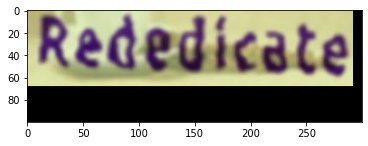

In [186]:
import re
file1 = open('./results/gt.txt', 'r')
Lines = file1.readlines()


data_F = [] # np.array([])#np.empty((n, ch, cw, 3))
data_L = [] # np.array([])

n = 0
count = 0
# Strips the newline character
for i,line in enumerate(Lines[0:2000]):
    d = re.split('\t', line)
    d[1] = d[1].replace('\n','')

    img = loadImage(f'results/{d[0]}')

    if( img.shape[0] <= ch and img.shape[0] >= 20 and img.shape[1] <= cw and img.shape[1] >= 80):

      n += 1
      img = img
      # loaded_image = img.astype(np.uint8)
      loaded_image = np.array(negative_pad_image(img, ch, cw))
      # data_F[i] = loaded_image
      # data_L = np.append(data_L, d[1])
      loaded_image = loaded_image / 255
      data_F.append(loaded_image)
      data_L.append(d[1])


data_F = np.array(data_F)
data_L = np.array(data_L)
print(data_F.shape)
# Image.fromarray(np.uint8(data_F[0])).convert('RGB')
plt.imshow(data_F[0])


# img = sample_image.astype(np.uint8) 
# img = np.array(negative_pad_image(img, ch, cw))
# plt.imshow(img)

GELDS
(100, 300, 3)
(103, 170, 3)


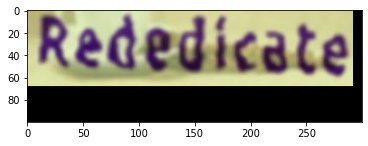

In [187]:
plt.imshow(data_F[0])

# print(data_F[10])
print(data_L[10])
print(x.shape)
print(img.shape)

In [188]:
alphabet = 'abcdefghijklmnopqrstuvwxyz./:;,\'"-_1234567890?!)(][}{><=*@#$%^&|~+'
alph_num = re.split('', alphabet)
alph_dict = dict({})

# alph_num.pop(0)
for j, c in enumerate(alph_num):
  alph_dict[c] = j

In [189]:
s = 'better'
alph_dict
_id = list(map(lambda c: alph_dict[c], s))
_id
# data_L_dist = to_categorical(data_L[0])

[2, 5, 20, 20, 5, 18]

In [202]:
m = lambda x: [alph_dict[c] for c in x]

data_L_id = np.zeros((n,75))
for k,data in enumerate(data_L):
  data = data.lower()
  ids = m(data)
  # data_L_id = np.append(data_L_id, [ids], axis=0)
  data_L_id[k][0:len(ids)] = ids[:]
  # data_L_id = np.append(data_L_id, m(data), axis=0)

In [203]:
data_L_dist = to_categorical(data_L_id)

In [204]:
data_L_dist.shape

(329, 75, 67)

In [205]:
data_F.shape

(329, 100, 300, 3)

In [206]:
len(alphabet)

66

### Model

In [207]:
train_F, test_F, train_L_dist, test_L_dist = train_test_split(data_F, data_L_dist, test_size=0.1, random_state=0)

In [208]:
train_F.shape, test_F.shape, train_L_dist.shape, test_L_dist.shape

((296, 100, 300, 3), (33, 100, 300, 3), (296, 75, 67), (33, 75, 67))

In [209]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(train_F, train_L_dist, batch_size=10)
test_gen = datagen.flow(test_F, test_L_dist, batch_size=10)

In [210]:
epochs = 15
batch_size = 10
train_steps = train_F.shape[0] // batch_size
valid_steps = train_L_dist.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [211]:
img_w = cw
img_h = ch
words_per_epoch = 16000
val_split = 0.2
val_words = int(words_per_epoch * (val_split))

# Network parameters
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
minibatch_size = 10

# model1=Sequential()


# model1.add(InputLayer(input_shape=(cw,ch,3)))

# #model1.add(Lambda(standardize,input_shape=(28,28,1)))    
# model1.add(
#     Conv2D(
#         filters=conv_filters, 
#         kernel_size = (3,3), 
#         activation="relu",
#         # kernel_initializer='he_normal'
#       )
#   )

# model1.add(MaxPooling2D(pool_size=(2,2)))

# model1.add(Conv2D(filters=conv_filters, kernel_size = (3,3), activation="relu", kernel_initializer='he_normal'))

# model1.add(MaxPooling2D(pool_size=(2,2)))

# model1.add(Conv2D(filters=conv_filters, kernel_size = (3,3), activation="relu", kernel_initializer='he_normal'))
# model1.add(Conv2D(filters=conv_filters, kernel_size = (3,3), activation="relu", kernel_initializer='he_normal'))

# model1.add(MaxPooling2D(pool_size=(2,2)))

# model1.add(Conv2D(filters=conv_filters, kernel_size = (3,3), activation="relu", kernel_initializer='he_normal'))

# model1.add(BatchNormalization())

# model1.add(Conv2D(filters=conv_filters, kernel_size = (3,3), activation="relu", kernel_initializer='he_normal'))

# model1.add(BatchNormalization())

# model1.add(MaxPooling2D(pool_size=(2,2)))

# model1.add(Conv2D(filters=conv_filters, kernel_size = (3,3), activation="relu", kernel_initializer='he_normal'))

# model1.add(Flatten())

# model1.add(Bidirectional(LSTM(10, return_sequences=True))
# # model1.add(LSTM(256))

# model1.add(Dense(55))

# conv_to_rnn_dims = (img_w // (pool_size ** 2),
#                     (img_h // (pool_size ** 2)) * conv_filters)


# model1.add(Reshape(target_shape=conv_to_rnn_dims))

# model1.add(Flatten())

# model1.add(Dense(time_dense_size, activation='relu'))


# gru1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal')
# gru2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', go_backwards=True)
# # gru_merged = Add()([gru1, gru2]) #add([gru1, gru2])
# # model1.add(gru_merged)

# gru1b = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal')
# gru2b = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', go_backwards=True)
# gru2b_concat = concatenate(gru1b, gru2b)
# model1.add(gru2b_concat)
# model1.summary()



# model1.add(Dense(20, activation='softmax', kernel_initializer='he_normal'))
# model1.add()

input_shape = (ch, cw, 3)

act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
                activation=act, kernel_initializer='he_normal',
                name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
                activation=act, kernel_initializer='he_normal',
                name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2),
                    (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True,
              go_backwards=True, kernel_initializer='he_normal',
              name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,
              kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(67, kernel_initializer='he_normal', name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)

prediction_model = Model(inputs=input_data, outputs=y_pred)
prediction_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

prediction_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 100, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 300, 16) 448         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 50, 150, 16)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 50, 150, 16)  2320        max1[0][0]                       
____________________________________________________________________________________________

In [212]:
train_L_dist.shape

(296, 75, 67)

In [213]:
# Fit the model
metrics1 = prediction_model.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp]
                              )

Epoch 1/15
29/29 [==============================] - 68s 2s/step - loss: 0.5352 - acc: 0.8850 - val_loss: 0.2783 - val_acc: 0.9269
Epoch 2/15
29/29 [==============================] - 60s 2s/step - loss: 0.3093 - acc: 0.9215 - val_loss: 0.2698 - val_acc: 0.9297
Epoch 3/15
29/29 [==============================] - 63s 2s/step - loss: 0.3048 - acc: 0.9211 - val_loss: 0.2651 - val_acc: 0.9290
Epoch 4/15
29/29 [==============================] - 61s 2s/step - loss: 0.2920 - acc: 0.9228 - val_loss: 0.2627 - val_acc: 0.9299
Epoch 5/15
29/29 [==============================] - 63s 2s/step - loss: 0.2961 - acc: 0.9224 - val_loss: 0.2607 - val_acc: 0.9301
Epoch 6/15
29/29 [==============================] - 64s 2s/step - loss: 0.2843 - acc: 0.9235 - val_loss: 0.2539 - val_acc: 0.9313
Epoch 7/15
29/29 [==============================] - 63s 2s/step - loss: 0.2925 - acc: 0.9221 - val_loss: 0.2667 - val_acc: 0.9286
Epoch 8/15
29/29 [==============================] - 64s 2s/step - loss: 0.2836 - acc: 0.92

### Predict

'dee'

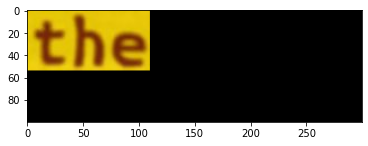

In [227]:
plt.imshow(data_F[27])

yhat2 = prediction_model.predict(data_F[27].reshape(1,ch,cw,3))

r = ''
for i in range(15):
  r += alph_num[yhat2[0][i].argmax()]

r

In [225]:
sample_image = loadImage('./america.png')
loaded_image = np.array(negative_pad_image(img, ch, cw))
loaded_image = loaded_image / 255

yhat2 = prediction_model.predict(loaded_image.reshape(1,ch,cw,3))

r = ''
for i in range(15):
  r += alph_num[yhat2[0][i].argmax()]

r

'ceaeeie'

(1, 75, 67)
[[[3.1159853e-03 7.0423707e-02 3.4311935e-02 ... 2.9715506e-04
   2.7394324e-04 7.1620545e-04]
  [2.2530875e-03 9.0297416e-02 2.3205509e-02 ... 1.0561209e-04
   1.1816978e-04 4.9352890e-04]
  [2.3104828e-03 7.1521021e-02 1.8563477e-02 ... 7.2308496e-05
   5.5456530e-05 5.7472137e-04]
  ...
  [9.9999928e-01 1.8663520e-09 7.0545907e-09 ... 2.1485666e-10
   5.2579628e-11 1.7971440e-10]
  [9.9999917e-01 3.6097905e-09 7.7070208e-09 ... 3.6868736e-10
   6.2497632e-11 2.5691244e-10]
  [9.9999905e-01 3.9683536e-09 9.1133110e-09 ... 4.0657455e-10
   7.1049770e-11 2.8669234e-10]]]
5


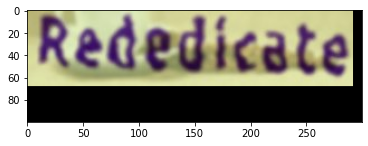

In [215]:
# View sample image and predicted label together

sample_image = loadImage('./results/images/0/0.jpg')
# Image.fromarray(np.uint8(sample_image*255)).convert('RGB')
img = sample_image.astype(np.uint8) 
img = np.array(negative_pad_image(img, ch, cw))

plt.imshow(img)

yhat = prediction_model.predict(img.reshape(1, ch, cw, 3))
yhat.shape

print(yhat.shape)
print(yhat)
print(yhat[0][3].argmax())

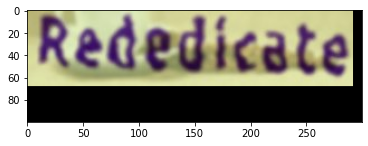

In [216]:
x = img.astype(np.uint8)
plt.imshow(x)